## Modèle de Biomasse Sèche REPO

In [ ]:
# changez cette variable à True si vous exécutez ce Notebook dans Google Colab,
# il installera les dépendances requises dans la cellule suivante
COLAB = True 

In [ ]:
if COLAB:
  !git clone https://github.com/gutkinn/REPO-biomasse.git
  %cd REPO-biomasse
  import os
  import yaml

  with open("environnement.yml") as file_handle:
    environment_data = yaml.safe_load(file_handle)

  for dependency in environment_data["dependencies"]:
      if isinstance(dependency, dict):
        for lib in dependency['pip']:
          os.system(f"pip install {lib}")
      else:
        os.system(f"pip install {dependency}")
  print('Parfait, bon pour aller !')

#### Importation des paquets nécessaires et fonctions supplémentaires

Tous les paquets Python doivent être importés pour le fonctionnement correct du modèle. S'il y a un paquet qui manque, suivez les instructions dans le fichier 'README.MD' pour l'installer. 
Les fonctions dans le fichier 'helpers' sont le moteur du Notebook, elles font toutes les calculs avec des variables définies à chaque étape.

In [1]:
import openeo
import pandas as pd
from helpers import *

### Étape 1. Extraction des données satellitaires (points d'entraînement)

Ici nous definissons toutes les variables qui seront nécessaires aux premières étapes de la prédiction de biomasse sèche. Les données biomasses collectées en terrain doivent être déjà préparées en avance - suivez les instructions dans le fichier 'Préparation_des_données.txt'.

In [2]:
in_csv = r'./in_data/donnees_sites_2023.csv'
prodsites = create_gpkg(in_csv)


In [3]:
# créneau temporel pour l'extraction des données satellitaires
t = ['2023-01-01','2023-12-31']

# toutes les géométries dont on aura besoin pour extraire les données satellitaires
geoms, bbox_simple, prodsites, band_list_s1, band_list_s2 = generate_geometries(prodsites)

# le nom du fichier ou télécharger les données d'entrée
points_out = os.path.join('.','out_data',f'points_biomasse_2023.json')

Puis, il faut se connecter au service openEO pour être autorisé à extraire les données satellitaires. Pour créer un compte openEO, suivez les instructions ici : https://docs.openeo.cloud/join/free_trial.html 

In [11]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Quand vous êtes connectés à openEO, vous pouvez envoyer un 'job': dont une demande d'extraire les données satellitaires pour tous les points d'entraînement. Ces données seront téléchargées dans votre fichier 'data' et peuvent être utilisées pour l'entraînement des modèles. 

In [10]:
# extraire les points d'entraînement
extr_agg = extract_and_save_simple(band_list_s1,band_list_s2,t,bbox_simple,geoms,connection)

# titre en format (exemple) : extraction_2023-01-01_2023-12-31 
job = extr_agg.create_job(
        title=f'extraction_{t[0]}_{t[1]}', out_format="JSON") 

job.start_and_wait()

for asset in job.get_results().get_assets():
    asset.download(points_out)

0:00:00 Job 'j-2411041471a3415082ef2152a21e1697': send 'start'
0:00:12 Job 'j-2411041471a3415082ef2152a21e1697': queued (progress 0%)
0:00:17 Job 'j-2411041471a3415082ef2152a21e1697': queued (progress 0%)
0:00:24 Job 'j-2411041471a3415082ef2152a21e1697': queued (progress 0%)
0:00:32 Job 'j-2411041471a3415082ef2152a21e1697': queued (progress 0%)
0:00:42 Job 'j-2411041471a3415082ef2152a21e1697': queued (progress 0%)
0:00:54 Job 'j-2411041471a3415082ef2152a21e1697': queued (progress 0%)
0:01:10 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)
0:01:29 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)
0:01:53 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)
0:02:23 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)
0:03:01 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)
0:03:50 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)
0:04:49 Job 'j-2411041471a3415082ef2152a21e1697': running (progress N/A)


### Étape 2. Entraînement des modèles 

Nous pouvons ouvrir le fichier pour vérifier la qualité des données téléchargées ici.

In [4]:
extr_data = open_dataset(prodsites,points_out)

Après le téléchargement, les données satellitaires sont organisées par date (colonne) et placeau central (ligne). Mais pour construire des modèles robusts, c'est mieux de prendre une moyenne de tous les placeaux au niveau de 'Groupe'. Puis, il faut réorganiser les données telles que nous puisons voir la troisieme dimension des données, soit les bandes satellitaires. Dans cette étape nous allons nettoyer les données (supprimer les captures vides - NaN) et calculer les indices végétaux. 

In [5]:
# toutes les bandes qu'on va utiliser dans les modèles
all_indexes = ['VV', 'VH', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
               'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'GRVI', 'GNDVI', 'NBR',
               'NBR2', 'NDI54', 'NDRE1', 'STI', 'MSI',  'SAVI', 'MSAVI', 'IRECI',
               'VV-VH_rolling','VV+VH_rolling']

index_list, biomass_list, all_l1_time = preprocess_data(prodsites,extr_data,all_indexes,band_list_s1,band_list_s2)


Maintenant, nous avons deux tableaux importants : 
 - index_list : un tableau contenant toutes les données des bandes satellitaires et indices
 - biomass_list : un tableau contenant toutes les données biomasse 
 
Chaque tableau doit avoir la même forme (mais à l'envers). Par example:

 - index_list.shape = (28,228) = (número des bandes, número des points)
 - biomass_list.shape = (228,) =  (número des points,)

D'ici, nous pouvons commencer à entrainer les modèles avec les données. Il y a trois options pour les modèles : régression linéaire (régressions polynomiales inclus), moindres carrés partiels, et Random Forests (machine learning). Nous allons comparer les scores R² et Mean Absolute Error (MAE) pour déterminer leurs précisions et décider que modèle faut-il utiliser. 

In [6]:
X_df = pd.DataFrame(index_list.T,columns=all_indexes,index=all_l1_time)
y_df = pd.DataFrame(biomass_list,columns=['biomass'],index=all_l1_time)

model_dict = print_models(X_df,y_df)

Modèle régression linéaire (1°)
Min MAE: itération 4 score 160.147
Max R²: itération 19 score 0.666
Bandes restantes : ['B05' 'B12' 'NDVI' 'NBR2' 'NDI54' 'STI' 'SAVI' 'MSAVI' 'IRECI']


Modèle régression polynomiale (2°)
Min MAE: itération 21 score 177.816
Max R²: itération 26 score 0.602
Bandes restantes : ['NBR2' 'NDI54']


Modèle régression polynomiale (3°)
Min MAE: itération 26 score 183.752
Max R²: itération 26 score 0.604
Bandes restantes : ['NBR2' 'NDI54']


Modèle moindre carrés partiels (PLS)
Min MAE : itération 6 score 160.378
Max R² : itération 22 score 0.686
Bandes restantes : ['NDVI' 'NDWI' 'NBR' 'NBR2' 'SAVI']


Modèle Random Forests (RF)
Min MAE : itération 17 score 188.815
Max R² : itération 25 score 0.562
Bandes restantes : ['B12' 'NDI54' 'IRECI']


En regardant les résultats, nous voyons que le modèle linéaire est le plus précise (R² score le plus grand, MAE le plus bas). 

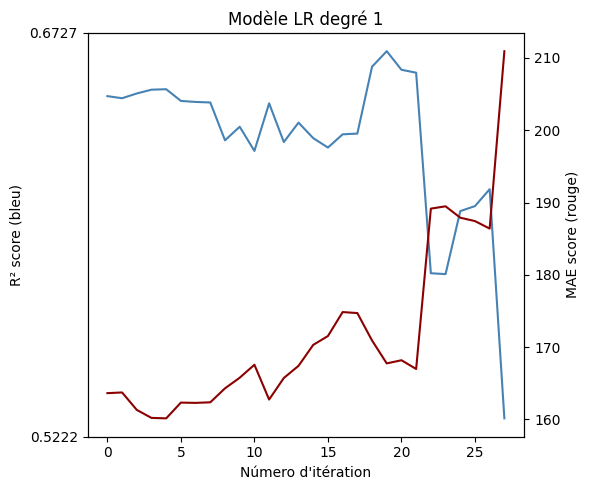

In [ ]:
model='LR' # options modèle : 'LR', 'PR2, 'PR3', 'PLS', ou 'RF'

draw_plot(model,X_df,y_df)

### Étape 3. Prédictions de la biomasse sèche

Compte tenu des données ci-dessus, nous allons choisir le modèle ayant le score R² le plus élevé. Nous utiliserons la fonction get_best_model() pour obtenir l'objet modèle que nous appliquerons à notre zone d'intérêt pour générer des prédictions de biomasse.

Nous avons chargé le « meilleur » modèle disponible, il nous faut maintenant récupérer les données d'entrée pour notre zone d'intérêt. Nous le ferons via openEO, en obtenant les données pour un polygone prédéfini et en les téléchargeant pour effectuer une inférence locale à l'aide du modèle que nous avons défini. Le processus de téléchargement peut prendre beaucoup de temps, car selon la taille de la zone spécifiée, il peut y avoir une très grande quantité de données.

In [6]:
commune = 'test' # 'test' si vous voulez tester la modèlisation avec un polygone de test 

# IMPORTANT : Il faut selectionner le mois entier pour avoir des prédictions de biomasse correctes
t_extract = ['2023-02-01', '2023-02-28']
bbox, area, mois, in_data_path = generate_geometries_zone(commune,t_extract)

In [ ]:
commune = 'test' # 'test' si vous voulez tester la modèlisation avec un polygone de test 

# IMPORTANT : Il faut selectionner le mois entier pour avoir des prédictions de biomasse correctes
t_extract = ['2023-02-01', '2023-02-28']

bbox, area, mois, in_data_path = generate_geometries_zone(commune,t_extract)
extr_area = extract_and_save_simple(band_list_s1,band_list_s2,t_extract,bbox,None,connection)

job = extr_area.create_job(
        title=f'prediction_{commune}_{t_extract[0]}_{t_extract[1]}', out_format='NetCDF')

job.start_and_wait()
for asset in job.get_results().get_assets():
    asset.download(in_data_path)

0:00:00 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': send 'start'
0:00:13 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': created (progress 0%)
0:00:18 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': created (progress 0%)
0:00:25 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': created (progress 0%)
0:00:33 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': created (progress 0%)
0:00:43 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:00:55 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:01:22 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:01:41 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:02:05 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:02:35 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:03:12 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': running (progress N/A)
0:03:59 Job 'j-241104ed0ccd40109ad9ea4fa39e2081': finished (progress 100%)


Des que les données ont été téléchargées, nous pouvons appliquer les modèles directement aux données pour générer des prédictions de la biomasse sèche. Avant d'applique le modèle, c'est important de calculer les mêmes indices vegetales lesquelles ont été utilisés pour l'entraînement du modèle. Nous allons le faire avec la fonction add_indices().  

In [7]:
in_data_path = os.path.join('.','out_data',f'{commune}_{mois}_100m.nc')
in_data, in_crs = get_in_data(in_data_path)
in_data

<xarray.Dataset>
Dimensions:        (x: 148, y: 144)
Coordinates:
  * x              (x) float64 6.904 6.905 6.906 6.906 ... 7.032 7.033 7.034
  * y              (y) float64 14.82 14.82 14.82 14.82 ... 14.7 14.7 14.7 14.7
Data variables: (12/31)
    VV             (y, x) float32 0.01264 0.01586 0.01661 ... 0.02665 0.01459
    VH             (y, x) float32 0.002332 0.001511 ... 0.003383 0.0004567
    B01            (y, x) float32 983.5 903.4 868.6 847.4 ... 879.4 875.0 978.8
    B02            (y, x) float32 1.637e+03 1.54e+03 ... 1.2e+03 1.598e+03
    B03            (y, x) float32 2.722e+03 2.753e+03 ... 1.824e+03 2.4e+03
    B04            (y, x) float32 4.155e+03 4.385e+03 ... 2.854e+03 3.468e+03
    ...             ...
    MSI            (y, x) float32 1.213 1.192 1.24 1.228 ... 1.382 1.433 1.319
    SAVI           (y, x) float32 0.1796 0.1714 0.1787 ... 0.2393 0.2605 0.2093
    MSAVI          (y, x) float32 0.7138 0.7049 0.7128 ... 0.775 0.7957 0.7449
    IRECI          (y, x) float32 634.4 580.2 704.6 718.7 ... 802.8 913.7 615.4
    VV-VH_rolling  (y, x) float64 0.01225 0.01244 0.01335 ... 0.01795 0.01548
    VV+VH_rolling  (y, x) float64 0.01692 0.01597 0.01672 ... 0.02239 0.01861

Finalement, c'est l'heure de générer des prédictions de la biomasse sèche utilisant les modèles dont nous avons entraîné et les données satellitaires dont nous avons téléchargé dans les étapes précedents. Les prédictions de biomasse seront calculé avec un minimum de 0kgMS/ha, même si le modèle nous donne une prédiction de biomasse negative. En changeont la variable _degree_, nous pouvons changer le modèle que nous allons utiliser. Si vous vous rappelez, le modèle de régression lineaire était le plus precise, donc nous allons continuer avec ce modèle (_degree_ = 1).

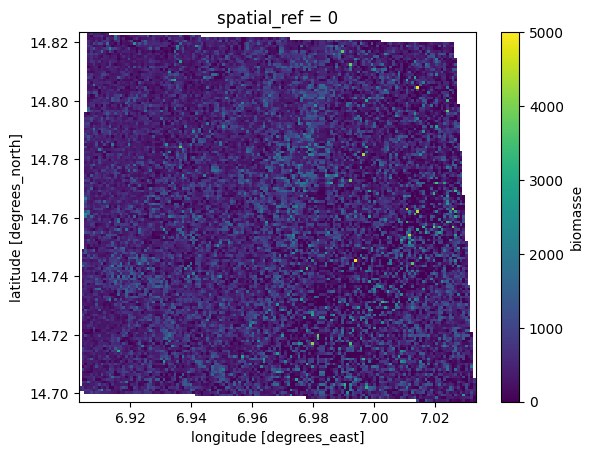

In [8]:
# options de modèle : 'LR', 'PR2, 'PR3', 'PLS', ou 'RF'
model = 'LR'
X_df = pd.DataFrame(index_list.T,columns=all_indexes,index=all_l1_time)
y_df = pd.DataFrame(biomass_list,columns=['biomass'],index=all_l1_time)
out_path = in_data_path.replace('100m','MODEL').replace('.nc','.tif')

generate_predictions(model, X_df, y_df, in_data, in_crs, out_path, area)